**Warning!**

Hi reader! This is a copy of a notebook from the `explore/12-tcnn-abilities` branch (`training.ipynb`), in which I only changed some procedure calls (as they are now in separate packages as `hbo_bench`, `btcnn`). I did not repeat the training itself, and I took the model weights and error values during the training from `clearml` logs.

In [1]:
import os
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
BTCNN_PATH = os.path.join(ROOT_PATH, "btcnn/src/btcnn")
HBO_BENCH_PATH = os.path.join(ROOT_PATH, "hbo_bench/src/hbo_bench")
EXPERIMENT_PATH = os.getcwd()
ARTIFACTS_PATH = os.path.join(EXPERIMENT_PATH, "artifacts")

In [2]:
from collections import defaultdict
from json import load, dumps, dump

from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from hbo_bench.utils import get_logical_tree, get_full_plan, get_selectivities, extract_list_info
from hbo_bench.oracle import Oracle, OracleRequest, TIMEOUT
from hbo_bench.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from hbo_bench.data_types import ExplainNode
from hbo_bench.vectorization import extract_vertices_and_edges, ALL_FEATURES
from hbo_bench.dataset import WeightedBinaryTreeDataset, weighted_binary_tree_collate

from btcnn.layers import *
from btcnn.regressor import BinaryTreeRegressor

# Loading data

## Step 1. Preprocessing plans
Here we load from Oracle (for `JOB` and `SQ`) data with queries and their plans under different parameters and then processing these plans to pairs vertices, edges.

In [3]:
job_oracle = Oracle(f"{HBO_BENCH_PATH}/data/processed/JOB")

job_list_info = extract_list_info(oracle=job_oracle, query_names=job_oracle.get_query_names())
job_list_vertices, job_list_edges, job_list_time = [[info[key] for info in job_list_info] for key in ["vertices", "edges", "time"]]

job_max_possible_size = len(job_oracle.get_query_names()) * len(DOPS) * len(HINTSETS)
print(f"[JOB]: dataset size is {len(job_list_info)} / {job_max_possible_size}")

[JOB]: dataset size is 43392 / 43392


In [4]:
sq_oracle = Oracle(f"{HBO_BENCH_PATH}/data/processed/sample_queries")

sq_list_info = extract_list_info(oracle=sq_oracle, query_names=sq_oracle.get_query_names())
sq_list_vertices, sq_list_edges, sq_list_time = [[info[key] for info in sq_list_info] for key in ["vertices", "edges", "time"]]

sq_max_possible_size = len(sq_oracle.get_query_names()) * len(DOPS) * len(HINTSETS)
print(f"[SQ]: dataset size is {len(sq_list_info)} / {sq_max_possible_size}")

[SQ]: dataset size is 15360 / 15360


In [5]:
job_X = set([(str(v.flatten().tolist()), str(e.flatten().tolist())) for v, e in zip(job_list_vertices, job_list_edges)])
sq_X = set([(str(v.flatten().tolist()), str(e.flatten().tolist())) for v, e in zip(sq_list_vertices, sq_list_edges)])
print(f"Around {100 * len(sq_X & job_X) / len(sq_X):0.1f} % of plans from SQ bench exists in JOB bench")

Around 23.0 % of plans from SQ bench exists in JOB bench


## Step 2. Splitting data to train-val / test sets

Since the queries from `SQ` are also over imdb data, we can use them as a test dataset. However, some of them are very different in nature from queries from `JOB`, so we will create two versions of the test dataset - in-distrubtion and out-of-distribution versions. We will consider a query as a in-distribution (`id` query) if its default logical tree occurs among the default logical trees of `JOB`s queries, otherwise we will call it a out-of-distribution (`ood`) query.

In [6]:
job_logical_trees = set(
    get_logical_tree(job_oracle.get_explain_plan(OracleRequest(query_name=query_name, hintset=hintset, dop=dop)))
    for query_name in job_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
)

ood_sq_list_info, id_sq_list_info = [], []
for info in sq_list_info:
    logical_tree = get_logical_tree(sq_oracle.get_explain_plan(OracleRequest(query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"])))
    if logical_tree not in job_logical_trees:
        ood_sq_list_info.append(info)
    else:
        id_sq_list_info.append(info)
        
ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time = [[info[key] for info in ood_sq_list_info] for key in ["vertices", "edges", "time"]]
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in id_sq_list_info] for key in ["vertices", "edges", "time"]]
assert len(ood_sq_list_info) + len(id_sq_list_info) == len(sq_list_info), "Something went wrong ..."

In [7]:
torch.save(job_list_info, f"{ARTIFACTS_PATH}/job_list_info")
torch.save(ood_sq_list_info, f"{ARTIFACTS_PATH}/ood_sq_list_info")
torch.save(id_sq_list_info, f"{ARTIFACTS_PATH}/id_sq_list_info")

## Step 3. Creating `torch.Datasets`
We see that most of the plans are repetitive. This is the reason for switching to weighted datasets (and dataloaders) to speed up the learning process. It also simplifies the landscape, leaving the solving of collision problem to the preprocessing stage.

In [78]:
job_all_plans = [
    get_full_plan(job_oracle.get_explain_plan(OracleRequest(query_name=query_name, hintset=hintset, dop=dop)))
    for query_name in job_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
]
print(f"[JOB]: total # of unique plans: {len(set(job_all_plans))} / {len(job_all_plans)}")

sq_all_plans = [
    get_full_plan(sq_oracle.get_explain_plan(OracleRequest(query_name=query_name, hintset=hintset, dop=dop)))
    for query_name in sq_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
]
print(f"[SQ]: total # of unique plans: {len(set(sq_all_plans))} / {len(sq_all_plans)}")

[JOB]: total # of unique plans: 7429 / 43392
[SQ]: total # of unique plans: 4496 / 15360


In [79]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cpu


In [80]:
job_weighted_dataset = WeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)
print(f"[JOB]: total # of unique plans in the weighted dataset {len(job_weighted_dataset)}")

ood_sq_weighted_dataset = WeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE)
print(f"[SQ, OOD]: total # of unique plans in the weighted dataset {len(ood_sq_weighted_dataset)}")

id_sq_weighted_dataset = WeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
print(f"[SQ, ID]: total # of unique plans in the weighted dataset {len(id_sq_weighted_dataset)}")

[JOB]: total # of unique plans in the weighted dataset 7323
[SQ, OOD]: total # of unique plans in the weighted dataset 3409
[SQ, ID]: total # of unique plans in the weighted dataset 1021


# Architectures

Here we set up some grid of architectures to be searched.



In [11]:
in_channels = len(ALL_FEATURES)

In [ ]:
no_btcnn = lambda: BinaryTreeSequential(
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

small_btcnn = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, in_channels),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

medium_btcnn = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 128),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, in_channels),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

small_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(in_channels, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

medium_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(in_channels, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [ ]:
def initialize_models():
    return [
        BinaryTreeRegressor(no_btcnn(), small_fcnn(), "NoBTCNN_SmallFCNN"),
        BinaryTreeRegressor(no_btcnn(), medium_fcnn(), "NoBTCNN_MediumFCNN"),
        BinaryTreeRegressor(small_btcnn(), small_fcnn(), "SmallBTCNN_SmallFCNN"),
        BinaryTreeRegressor(small_btcnn(), medium_fcnn(), "SmallBTCNN_MediumFCNN"),
        BinaryTreeRegressor(medium_btcnn(), small_fcnn(), "MediumBTCNN_SmallFCNN"),
        BinaryTreeRegressor(medium_btcnn(), medium_fcnn(), "MediumBTCNN_MediumFCNN"),
    ]

In [9]:
big_btcnn = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_frozen_layer_norm = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeLayerNorm(128, frozen=True),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeLayerNorm(256, frozen=True),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_frozen_instance_norm = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeInstanceNorm(128, frozen=True),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeInstanceNorm(256, frozen=True),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_layer_norm = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeLayerNorm(128),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeLayerNorm(256),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_instance_norm = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeInstanceNorm(128),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeInstanceNorm(256),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [ ]:
def initialize_big_models():
    return [
        BinaryTreeRegressor(big_btcnn(), big_fcnn(), "BigBTCNN_BigFCNN"),
        BinaryTreeRegressor(big_btcnn_and_frozen_layer_norm(), big_fcnn(), "BigBTCNN_BigFCNN_FrozenLayerNorm"),
        BinaryTreeRegressor(big_btcnn_and_frozen_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_FrozenInstanceNorm"),
        BinaryTreeRegressor(big_btcnn_and_layer_norm(), big_fcnn(), "BigBTCNN_BigFCNN_LayerNorm"),
        BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm"),
    ]

# Training

## Preparation

In [23]:
max_length = max([v.shape[0] for v in job_list_vertices + ood_sq_list_vertices + id_sq_list_vertices])
print(f"The longest tree has length {max_length}")
batch_size = 256
lr = 3e-4

In [ ]:
def generate_dataloaders(n):
    res = []
    for seed in range(42, 42+n):
        generator = torch.Generator().manual_seed(seed)
        train_dataset, val_dataset = torch.utils.data.dataset.random_split(job_weighted_dataset, [0.8, 0.2], generator=generator)
        test_dataset = id_sq_weighted_dataset
        ood_dataset = ood_sq_weighted_dataset
        train_dataloader, val_dataloader, test_dataloader, ood_dataloader = [
            DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=True,
                collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
                drop_last=False
            )
            for dataset in [train_dataset, val_dataset, test_dataset, ood_dataset]
        ]        
        yield (train_dataloader, val_dataloader, test_dataloader, ood_dataloader)

In [ ]:
def calculate_loss(model, optimizer, criterion, dataloader, train_mode=True):
    model.train() if train_mode else model.eval()
    running_loss, total_samples = .0, 0
    for (vertices, edges, freq), time in dataloader:
        if train_mode:
            optimizer.zero_grad()
        
        outputs = model(vertices, edges)
        weighted_loss = (freq.float().squeeze(-1) * criterion(outputs.squeeze(-1), time)).mean()
        
        if train_mode:
            weighted_loss.backward()
            optimizer.step()

        running_loss += weighted_loss.item() * vertices.size(0)
        total_samples += freq.sum()
    return running_loss / total_samples

In [ ]:
def save_ckpt(model, optimizer, scheduler, epoch, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
def weighted_train_loop(
    model,  optimizer,  criterion, scheduler, train_dataloader, num_epochs, clearml_task, 
    start_epoch=0, metadata=None, ckpt_period=10, eval_period=10, path_to_save=None, val_dataloader=None, test_dataloader=None, ood_dataloader=None
    ):
        with torch.no_grad():
            train_loss = calculate_loss(model, optimizer, criterion, train_dataloader, train_mode=False)
            clearml_task.get_logger().report_scalar("MSE [train]", model.name, iteration=0, value=train_loss)
            if val_dataloader:
                val_loss = calculate_loss(model, optimizer, criterion, val_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [val]", model.name, iteration=0, value=val_loss)
            if test_dataloader:
                test_loss = calculate_loss(model, optimizer, criterion, test_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [test]", model.name, iteration=0, value=test_loss)
            if ood_dataloader:  
                ood_loss = calculate_loss(model, optimizer, criterion, ood_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [ood]", model.name, iteration=0, value=ood_loss)            

        tqdm_desc = "Initialization"
        progress_bar = tqdm(range(start_epoch + 1, start_epoch + num_epochs + 1), desc=tqdm_desc, leave=True, position=0)
        for epoch in progress_bar:
            train_loss = calculate_loss(model, optimizer, criterion, train_dataloader)
            scheduler.step(train_loss)
            clearml_task.get_logger().report_scalar("MSE [train]", model.name, iteration=epoch, value=train_loss)
            progress_bar.set_description(f'[{epoch}/{start_epoch + num_epochs}] MSE: {train_loss:.4f}')

            with torch.no_grad():
                if val_dataloader and not epoch % eval_period:
                    val_loss = calculate_loss(model, optimizer, criterion, val_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [val]", model.name, iteration=epoch, value=val_loss)
                if test_dataloader and not epoch % eval_period:
                    test_loss = calculate_loss(model, optimizer, criterion, test_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [test]", model.name,iteration=epoch, value=test_loss)
                if ood_dataloader and not epoch % eval_period:  
                    ood_loss = calculate_loss(model, optimizer, criterion, ood_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [ood]", model.name,iteration=epoch, value=ood_loss)            

            if path_to_save and not epoch % ckpt_period:
                save_ckpt(model, optimizer, scheduler, epoch, path_to_save)

In [ ]:
!pip install git+https://github.com/allegroai/clearml
!pip install clearml-agent
from clearml import Task

## Medium Models

In [ ]:
task = Task.init(project_name="hero", task_name='Medium Models')
assert task is not None

epochs = 300
metadata = {
    "data": "weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}

n_runs = 5
for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_dataloaders(n_runs), start=1):
    for model in initialize_models():
        model.name = model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

## Big Models

In [ ]:
task = Task.init(project_name="hero", task_name='Big Models')
assert task is not None

epochs = 300
metadata = {
    "data": "weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}

n_runs = 5
for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_dataloaders(n_runs), start=1):
    for model in initialize_big_models():
        model.name = model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

# Noised Data

Here we investigate the role of operation channels and statistics in vertex embedding. The goal is to understand whether tree structure alone or statistics alone is sufficient to predict time with equal accuracy.

In [3]:
def add_noise_to_vertices(v, channels, generator):
    noise = torch.rand(v.shape, device=v.device, generator=generator)
    res = v.clone()
    res[:,channels] = noise[:,channels]
    return res

In [4]:
class NoisedWeightedBinaryTreeDataset(WeightedBinaryTreeDataset):
    def __init__(
        self,
        list_vertices: "List[Tensor]",
        list_edges: "List[Tensor]",
        list_time: "List[Tensor]",
        device: "torch.device",
        noised_channels: "List[int]",  
        generator: "torch.Generator",
    ):
        super().__init__(list_vertices, list_edges, list_time, device)
        
        self.noised_channels = noised_channels
        for i, v in enumerate(self.list_vertices):
            self.list_vertices[i] = add_noise_to_vertices(v, channels=self.noised_channels, generator=generator)


In [ ]:
def generate_noised_dataloaders(n, noised_channels):
    res = []
    for seed in range(42, 42+n):
        generator = torch.Generator(device=DEVICE).manual_seed(seed)
        noised_trainval_dataset = NoisedWeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE, noised_channels, generator)
        noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
        noised_ood_dataset = NoisedWeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE, noised_channels, generator)
    
        generator = torch.Generator().manual_seed(seed)
        noised_train_dataset, noised_val_dataset = torch.utils.data.dataset.random_split(noised_trainval_dataset, [0.8, 0.2], generator=generator)

        train_dataloader, val_dataloader, test_dataloader, ood_dataloader = [
            DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=True,
                collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
                drop_last=False
            )
            for dataset in [noised_train_dataset, noised_val_dataset, noised_test_dataset, noised_ood_dataset]
        ]        
        yield (train_dataloader, val_dataloader, test_dataloader, ood_dataloader)

In [ ]:
task = Task.init(project_name="hero", task_name="Noised data")
assert task is not None

epochs = 150
metadata = {
    "data": "noised_weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}
n_runs = 10

for noised_channels, noise_description in [
    (range(len(ALL_FEATURES)), "all"), 
    (range(len(ALL_FEATURES)-2), "ops"), 
    (range(len(ALL_FEATURES)-2, len(ALL_FEATURES)), "stats"),
    ]:
    for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_noised_dataloaders(n_runs, noised_channels), start=1):
        model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm")
        model.name = "[" + noise_description + "] " + model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

# [code only for paper]

Let's check that there's no constant prediction on the noised data.

In [ ]:
from hero.train_utils import load_model
import matplotlib.pyplot as plt

In [ ]:
test_list_info = torch.load(f"{ARTIFACTS_PATH}/id_sq_list_info")
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in test_list_info] for key in ["vertices", "edges", "time"]]

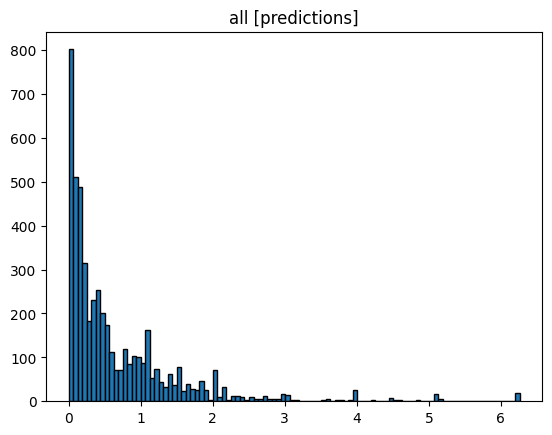

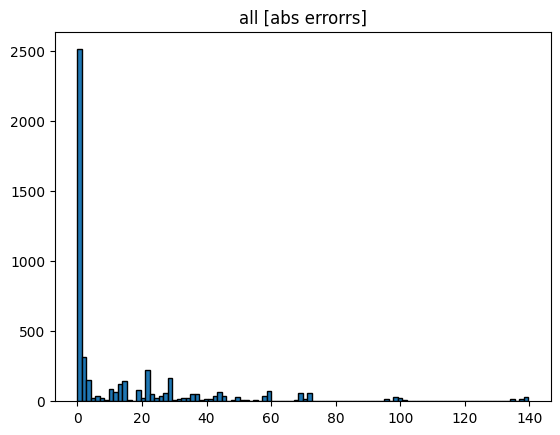

MAE: 15.1349 [all]
MSE: 861.0051 [all]
Total Abs Error: 75553.35285923892 [all]


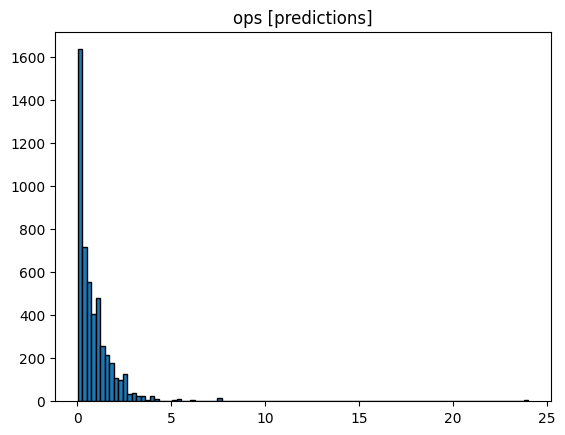

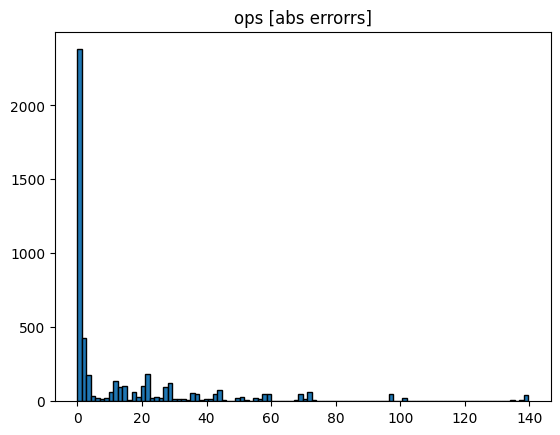

MAE: 15.0654 [ops]
MSE: 856.3405 [ops]
Total Abs Error: 75206.44994858513 [ops]


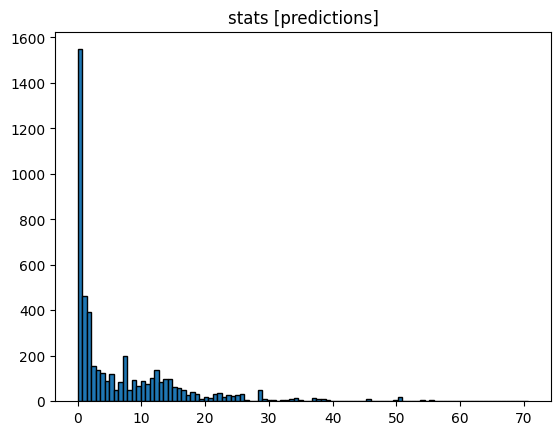

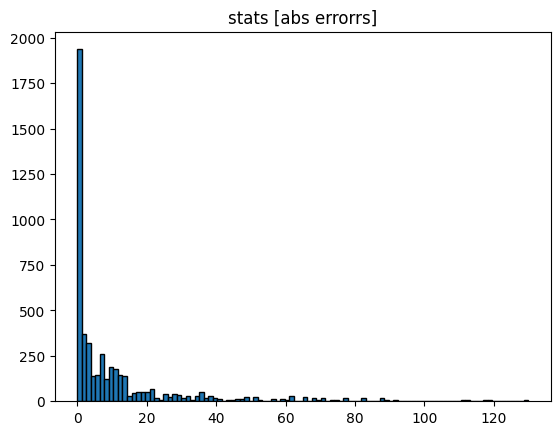

MAE: 11.7200 [stats]
MSE: 536.6716 [stats]
Total Abs Error: 58506.03444487578 [stats]


In [85]:
run = 10
seed = 42 + run - 1
for noised_channels, noise_description in [
    (range(len(ALL_FEATURES)), "all"), 
    (range(len(ALL_FEATURES)-2), "ops"), 
    (range(len(ALL_FEATURES)-2, len(ALL_FEATURES)), "stats"),
    ]:
    model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm")
    model_name = "[" + "stats" + "] " + "BigBTCNN_BigFCNN_InstanceNorm_" + str(run)
    model = load_model(
        device=DEVICE, 
        path=f"{EXPERIMENT_PATH}/models/{model_name}.pth",
        model=model
    )

    generator = torch.Generator(device=DEVICE).manual_seed(seed)
    
    noised_trainval_dataset = NoisedWeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE, noised_channels, generator)
    noised_train_dataset, noised_val_dataset = torch.utils.data.dataset.random_split(noised_trainval_dataset, [0.8, 0.2], generator=generator)
    noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
    
    noised_train_dataloader = DataLoader(
        dataset=noised_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )  
    noised_val_dataloader = DataLoader(
        dataset=noised_val_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )      
    noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
    noised_test_dataloader = DataLoader(
        dataset=noised_test_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )    

    predictions, abs_errors = [], []
    model.eval()
    with torch.no_grad():
        for (vertices, edges, freq), time in noised_test_dataloader:    
            for f, p, t in zip(freq, list(model(vertices, edges)), time):
                for _ in range(int(f)):
                    predictions.append(float(p))
                    abs_errors.append(float(abs(p-t)))
    
    plt.hist(predictions, bins=100, edgecolor='black')
    plt.title(noise_description + " [predictions]")
    plt.show()

    plt.hist(abs_errors, bins=100, edgecolor='black')
    plt.title(noise_description + " [abs errorrs]")    
    plt.show()
    
    print(f"MAE: {sum(abs_errors) / len(abs_errors):0.4f} [{noise_description}]")
    print(f"MSE: {sum(e ** 2 for e in abs_errors) / len(abs_errors):0.4f} [{noise_description}]")
    print(f"Total Abs Error: {sum(abs_errors)} [{noise_description}]")

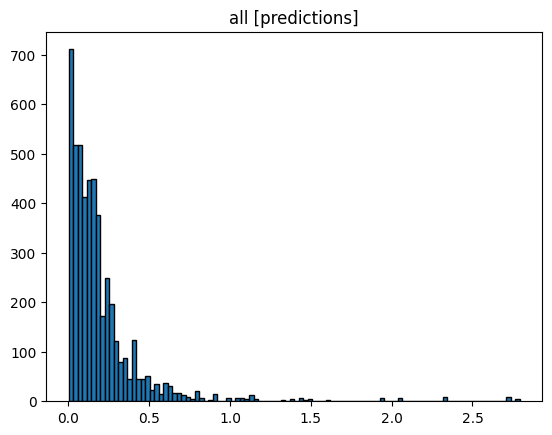

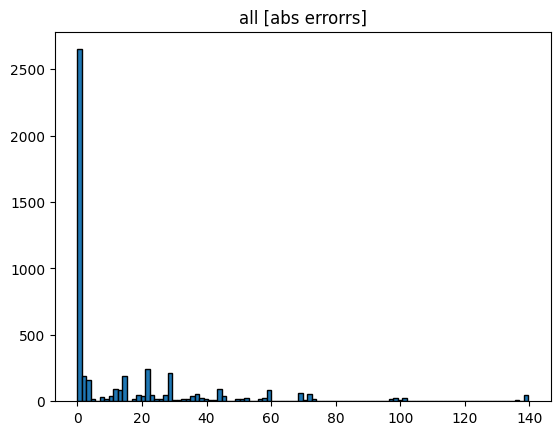

MAE: 15.1749 [all]
MSE: 877.0742 [all]
Total Abs Error: 75753.30374757701 [all]


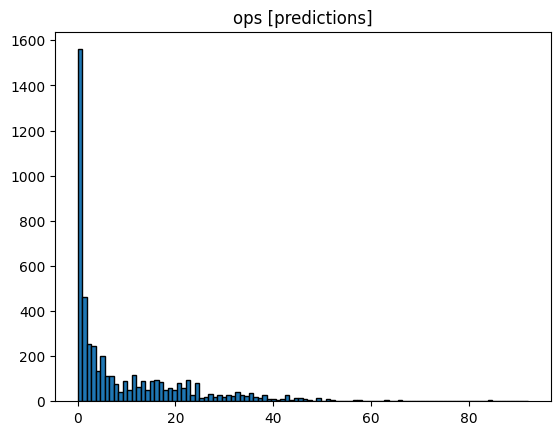

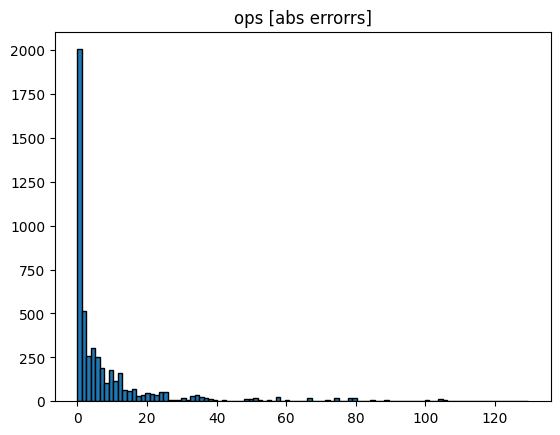

MAE: 9.1855 [ops]
MSE: 370.1582 [ops]
Total Abs Error: 45854.11738918087 [ops]


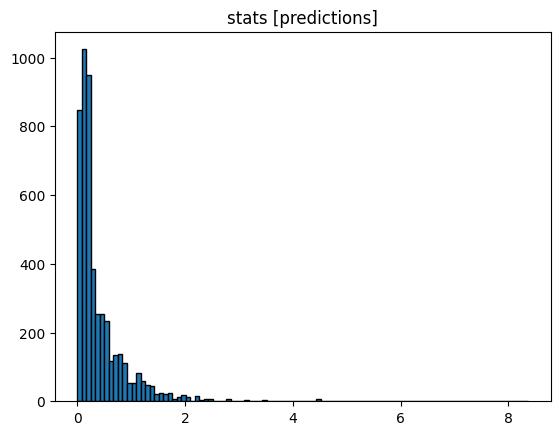

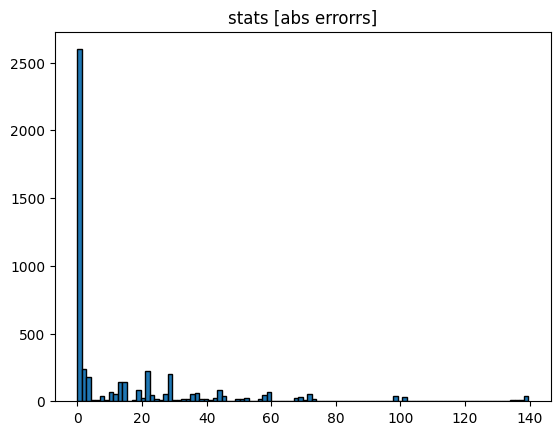

MAE: 15.1536 [stats]
MSE: 870.8189 [stats]
Total Abs Error: 75646.53016892448 [stats]


In [84]:
run = 10
seed = 42 + run - 1
for noised_channels, noise_description in [
    (range(len(ALL_FEATURES)), "all"), 
    (range(len(ALL_FEATURES)-2), "ops"), 
    (range(len(ALL_FEATURES)-2, len(ALL_FEATURES)), "stats"),
    ]:
    model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm")
    model_name = "[" + "ops" + "] " + "BigBTCNN_BigFCNN_InstanceNorm_" + str(run)
    model = load_model(
        device=DEVICE, 
        path=f"{EXPERIMENT_PATH}/models/{model_name}.pth",
        model=model
    )

    generator = torch.Generator(device=DEVICE).manual_seed(seed)
    
    noised_trainval_dataset = NoisedWeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE, noised_channels, generator)
    noised_train_dataset, noised_val_dataset = torch.utils.data.dataset.random_split(noised_trainval_dataset, [0.8, 0.2], generator=generator)
    noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
    
    noised_train_dataloader = DataLoader(
        dataset=noised_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )  
    noised_val_dataloader = DataLoader(
        dataset=noised_val_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )      
    noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
    noised_test_dataloader = DataLoader(
        dataset=noised_test_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda el: weighted_binary_tree_collate(el, 66),
        drop_last=False
    )    

    predictions, abs_errors = [], []
    model.eval()
    with torch.no_grad():
        for (vertices, edges, freq), time in noised_test_dataloader:    
            for f, p, t in zip(freq, list(model(vertices, edges)), time):
                for _ in range(int(f)):
                    predictions.append(float(p))
                    abs_errors.append(float(abs(p-t)))
    
    plt.hist(predictions, bins=100, edgecolor='black')
    plt.title(noise_description + " [predictions]")
    plt.show()

    plt.hist(abs_errors, bins=100, edgecolor='black')
    plt.title(noise_description + " [abs errorrs]")    
    plt.show()
    
    print(f"MAE: {sum(abs_errors) / len(abs_errors):0.4f} [{noise_description}]")
    print(f"MSE: {sum(e ** 2 for e in abs_errors) / len(abs_errors):0.4f} [{noise_description}]")
    print(f"Total Abs Error: {sum(abs_errors)} [{noise_description}]")